In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Configuración para matplotlib en Colab
%matplotlib inline

In [2]:
# Tamaño del tablero
GRID_SIZE = 9
CELL_SIZE = 50

# Sudoku predefinido (0 representa casillas vacías)
sudoku_puzzle = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

In [27]:
# Posiciones de los números fijos
fixed_positions = {(r, c) for r in range(GRID_SIZE) for c in range(GRID_SIZE) if sudoku_puzzle[r][c] != 0}

def draw_grid(grid, generation, fitness_score):
    """Dibuja el Sudoku usando Matplotlib"""
    clear_output(wait=True)
    plt.figure(figsize=(8, 8))
    plt.title(f"Generación: {generation} - Fitness: {fitness_score}", fontsize=14)
    #plt.imshow(np.ones((GRID_SIZE, GRID_SIZE)) * 0.1, cmap="gray", extent=[0, GRID_SIZE, 0, GRID_SIZE])
    plt.gca().set_facecolor((0.8, 0.8, 0.8))  # RGB: 0.8 es un gris claro

    # Dibujar cuadrícula
    for r in range(GRID_SIZE + 1):
        lw = 2 if r % 3 == 0 else 0.5
        plt.plot([0, GRID_SIZE], [r, r], 'k', linewidth=lw)
        plt.plot([r, r], [0, GRID_SIZE], 'k', linewidth=lw)

    # Añadir números
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            if grid[r][c] != 0:
                color = 'darkred' if (r, c) in fixed_positions else 'darkblue'
                plt.text(c + 0.5, GRID_SIZE - r - 0.5, str(grid[r][c]),
                        ha='center', va='center', fontsize=14, color=color, fontweight='bold')

    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close()  # Cerrar figura para liberar memoria

def generate_population(size):
    """Genera población inicial respetando números fijos"""
    return [np.array([[sudoku_puzzle[r][c] if (r,c) in fixed_positions
                      else random.randint(1, 9) for c in range(9)] for r in range(9)])
            for _ in range(size)]

def fitness(grid):
    """Calcula fitness basado en números únicos por filas y columnas"""
    score = 0
    
    # Penalización por números repetidos en filas
    for row in grid:
        unique = len(set(row))
        score += unique  # Más puntos por más números únicos
    
    # Penalización por números repetidos en columnas
    for col in grid.T:
        unique = len(set(col))
        score += unique  # Más puntos por más números únicos
    
    # Penalización por números repetidos en bloques 3x3
    for i in range(0, 9, 3):
        for j in range(0, 9, 3):
            block = grid[i:i+3, j:j+3].flatten()
            unique = len(set(block))
            score += unique  # Más puntos por más números únicos
    
    return score

def fitness2(grid):
    score = 0
    
    # Penalización por repeticiones en filas
    for row in grid:
        counts = np.bincount(row, minlength=10)[1:]
        repeticiones = np.sum(counts[counts > 1])
        score -= repeticiones * 2
    
    # Penalización por repeticiones en columnas
    for col in grid.T:
        counts = np.bincount(col, minlength=10)[1:]
        repeticiones = np.sum(counts[counts > 1])
        score -= repeticiones * 2
    
    # Penalización por repeticiones en bloques 3x3
    for i in range(0, 9, 3):
        for j in range(0, 9, 3):
            block = grid[i:i+3, j:j+3].flatten()
            counts = np.bincount(block, minlength=10)[1:]
            repeticiones = np.sum(counts[counts > 1])
            score -= repeticiones * 3
    
    # Penalización por modificar números fijos
    for r, c in fixed_positions:
        if grid[r][c] != sudoku_puzzle[r][c]:
            score -= 10
    
    return score

def crossover(p1, p2):
    """Cruzamiento por filas con probabilidad 50%"""
    mask = np.random.rand(9) < 0.5
    child = np.where(mask[:, None], p1, p2)
    return child

def mutate(grid, mutation_rate=0.05):
    """Mutación respetando números fijos"""
    mutation_mask = np.random.rand(*grid.shape) < mutation_rate
    random_values = np.random.randint(1, 10, grid.shape)
    return np.where(mutation_mask & ~np.array([[ (r,c) in fixed_positions
                                               for c in range(9)] for r in range(9)]),
                   random_values, grid)

def genetic_algorithm(pop_size=500, max_generations=10000, mutation_rate=0.2):
    population = generate_population(pop_size)
    best_fitness = float('-inf')
    best_solution = None
    stagnation_counter = 0
    mutation_rate = 0.2
    last_improvement = 0
    
    for generation in range(max_generations):
        # Evaluar población
        population.sort(key=lambda x: -fitness(x))
        current_best = population[0]
        current_fitness = fitness2(current_best)
        
        # Actualizar mejor solución
        if current_fitness > best_fitness:
            best_fitness = current_fitness
            best_solution = current_best.copy()
            stagnation_counter = 0
            last_improvement = generation
        else:
            stagnation_counter += 1
        
        # Mostrar progreso
        if generation % 10 == 0:
            draw_grid(best_solution, generation, best_fitness)
            print(f"Generación: {generation:4d} | Fitness: {best_fitness:3d}")
        
        # Condición de término
        if best_fitness == 0:
            print("\n¡Sudoku resuelto!")
            return best_solution
        
        # Estrategia de reinicio adaptativo
        if stagnation_counter > 50:
            # Reinicio parcial más agresivo
            keep_best = population[:pop_size//10]  # Mantener solo el 10% mejor
            new_pop = generate_population(pop_size - len(keep_best))
            population = keep_best + new_pop
            mutation_rate = min(0.5, mutation_rate * 1.5)
            stagnation_counter = 0
        
        # Mutación adaptativa basada en el tiempo sin mejora
        if generation - last_improvement > 200:
            mutation_rate = 0.5  # Mutación muy agresiva
            # Reinicio completo si no hay mejora por mucho tiempo
            if generation - last_improvement > 500:
                population = generate_population(pop_size)
                mutation_rate = 0.2
                last_improvement = generation
        
        # Selección y reproducción
        parents = population[:pop_size//4]  # Seleccionar mejores 25%
        new_pop = [best_solution.copy()]
        
        while len(new_pop) < pop_size:
            p1, p2 = random.choices(parents, k=2)
            child = mutate(crossover(p1, p2), mutation_rate)
            new_pop.append(child)
        
        population = new_pop
    
    return best_solution


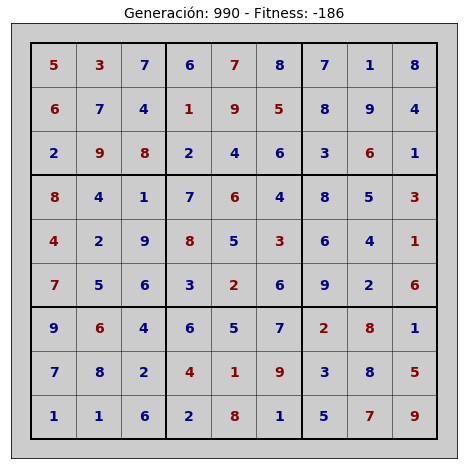

Generación:  990 | Fitness: -186


array([[5, 3, 7, 6, 7, 8, 7, 1, 8],
       [6, 7, 4, 1, 9, 5, 8, 9, 4],
       [2, 9, 8, 2, 4, 6, 3, 6, 1],
       [8, 4, 1, 7, 6, 4, 8, 5, 3],
       [4, 2, 9, 8, 5, 3, 6, 4, 1],
       [7, 5, 6, 3, 2, 6, 9, 2, 6],
       [9, 6, 4, 6, 5, 7, 2, 8, 1],
       [7, 8, 2, 4, 1, 9, 3, 8, 5],
       [1, 1, 6, 2, 8, 1, 5, 7, 9]])

In [29]:
# Ejecutar el algoritmo con parámetros ajustados
genetic_algorithm(pop_size=100, max_generations=1000, mutation_rate=0.1)